In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# make sure you add a shortcut of "295R-Caps-Pattern" folder to your own Drive if you're shared this folder
!ls "/content/drive/My Drive/297R-Caps-Pattern/Data"

clean  encodings  intermediate	raw  themes


In [4]:
# input folders
data = "/content/drive/My Drive/297R-Caps-Pattern/Data"

In [5]:
# get id column of both datasets
col_list = ["asin"]
bsr_asin = pd.read_csv(f'{data}/raw/asin_bsr_history.csv', usecols=col_list)
review_asin = pd.read_csv(f'{data}/raw/asin_review_history.csv', usecols=col_list)

In [6]:
prod_asin_rev = review_asin['asin'].unique()
prod_asin_bsr = bsr_asin['asin'].unique()
print(prod_asin_rev.shape, 'products in reviews')
print(prod_asin_bsr.shape, 'products in bsr')

# get interset of the two dataset
prod_asin = list(set(prod_asin_rev).intersection(set(prod_asin_bsr)))
print(len(prod_asin), 'products in intersection')

(9977,) products in reviews
(9991,) products in bsr
9958 products in intersection


### BSR data

In [7]:
# get id column of both datasets
bsr_full = pd.read_csv(f'{data}/raw/asin_bsr_history.csv')

In [8]:
bsr_full.head()

,Unnamed: 0,date,rank,avg180_price,asin
0,0,2017-07-03,9003.666667,17.01,B000139ZHU
1,1,2017-07-04,8211.666667,17.01,B000139ZHU
2,2,2017-07-05,6475.000000,17.01,B000139ZHU
3,3,2017-07-06,10318.000000,17.01,B000139ZHU
4,4,2017-07-07,8335.500000,17.01,B000139ZHU


In [9]:
# date range
bsr_full['date'].min(), bsr_full['date'].max() 

('2017-07-03', '2021-07-02')

In [10]:
min_dates = bsr_full.groupby(['asin'])['date'].min()
max_dates = bsr_full.groupby(['asin'])['date'].max()

In [11]:
min_dates.value_counts()

2017-07-03    3945
2017-07-04     472
2017-07-05     260
2017-07-06      53
2017-10-13      21
              ... 
2018-09-18       1
2018-03-19       1
2018-02-08       1
2018-02-23       1
2021-06-20       1
Name: date, Length: 1389, dtype: int64

In [12]:
max_dates.value_counts()

2021-07-02    9982
2021-07-01       5
2021-03-28       1
2021-02-05       1
2021-06-30       1
2021-06-29       1
Name: date, dtype: int64

In [13]:
bsr_movement = pd.DataFrame({'asin': bsr_full.groupby('asin')['rank'].max().index, 
                             'max': bsr_full.groupby('asin')['rank'].max(), 
                             'min': bsr_full.groupby('asin')['rank'].min()}).reset_index(drop=True)
bsr_movement['diff'] = bsr_movement['max'] - bsr_movement['min']

In [14]:
bsr_movement[['diff']].describe()

,diff
count,9.991000e+03
mean,2.568364e+05
std,3.360135e+05
min,4.746667e+02
25%,8.432039e+04
50%,1.728210e+05
75%,3.008015e+05
max,7.785554e+06


In [15]:
# QUESTION: why are there multiple rows within asin-date?
# QUESTION: why are there non-integer rank?   - ties? average over a day?
bsr_full.query('asin=="B00012NIAG"').sort_values('date')

,Unnamed: 0,date,rank,avg180_price,asin
11071437,11071437,2017-07-03,9964.000000,11.23,B00012NIAG
28639072,28639072,2017-07-03,9964.000000,11.23,B00012NIAG
18773977,18773977,2017-07-03,9964.000000,11.23,B00012NIAG
11071438,11071438,2017-07-04,9161.333333,11.23,B00012NIAG
28639073,28639073,2017-07-04,9161.333333,11.23,B00012NIAG
...,...,...,...,...,...
11072877,11072877,2021-07-01,28780.750000,11.23,B00012NIAG
18775417,18775417,2021-07-01,28780.750000,11.23,B00012NIAG
18775418,18775418,2021-07-02,26104.857143,11.23,B00012NIAG
11072878,11072878,2021-07-02,25649.666667,11.23,B00012NIAG


In [16]:
print(bsr_full['asin'].unique().shape[0], 'products')
print(bsr_full[['asin','date']].drop_duplicates().shape[0], 'product-date combinations')
print(bsr_full[['asin','date','rank']].drop_duplicates().shape[0], 'product-date-rank combinations')
print(bsr_full[['asin','date','avg180_price']].drop_duplicates().shape[0], 'product-date-price combinations')

9991 products
9706238 product-date combinations
9707698 product-date-rank combinations
10322729 product-date-price combinations


NOTE: rank/price differ within product-date

In [17]:
# product missing rank on certain days
bsr_sub = bsr_full[['date','rank','asin']].groupby(['date','asin'])['rank'].mean().to_frame().reset_index()
bsr_start = bsr_sub.groupby(['asin'])['date'].min().to_frame().reset_index().rename(columns={'date':'start'})
bsr_end = bsr_sub.groupby(['asin'])['date'].max().to_frame().reset_index().rename(columns={'date':'end'})
bsr_dates = bsr_start.merge(bsr_end, on='asin', how='outer')
del bsr_start 
del bsr_end
bsr_dates['start'] = pd.to_datetime(bsr_dates['start'])
bsr_dates['end'] = pd.to_datetime(bsr_dates['end'])
bsr_dates['days_in_bw'] = (bsr_dates['end'] - bsr_dates['start']).dt.days + 1 
bsr_dates = bsr_dates.merge(bsr_sub.groupby('asin')[['rank']].count().reset_index().rename(columns={'rank':'n_rank'}),
                            on='asin',how='outer')
bsr_dates.head()

,asin,start,end,days_in_bw,n_rank
0,2635214875,2020-02-21,2021-07-02,498,466
1,B000052XB5,2017-07-03,2021-07-02,1461,1460
2,B00005313T,2017-07-03,2021-07-02,1461,1460
3,B0000533I2,2017-07-03,2021-07-02,1461,1456
4,B00005K9DO,2017-07-03,2021-07-02,1461,1413


In [18]:
# not many have full rank history
(bsr_dates['days_in_bw'] == bsr_dates['n_rank']).mean()

0.11880692623361025

In [19]:
# though not many missing dates
(bsr_dates['n_rank'] / bsr_dates['days_in_bw']).mean()

0.9206648259538116

In [20]:
del bsr_dates

In [21]:
# e.g. no 2020-04-23 rank
bsr_full.query('asin == "2635214875" & date > "2020-04-21"').sort_values('date').head()

,Unnamed: 0,date,rank,avg180_price,asin
2521247,2521247,2020-04-22,6961.666667,60.32,2635214875
13981778,13981778,2020-04-22,6961.666667,60.32,2635214875
3484499,3484499,2020-04-22,6961.666667,60.32,2635214875
2521248,2521248,2020-04-24,6848.000000,60.32,2635214875
13981779,13981779,2020-04-24,6848.000000,60.32,2635214875


In [22]:
# but 2020-04-23 has data
bsr_full.query('date == "2020-04-23"')

,Unnamed: 0,date,rank,avg180_price,asin
1012,1012,2020-04-23,39751.200000,17.01,B000139ZHU
2401,2401,2020-04-23,75320.750000,19.65,B000154TMO
3837,3837,2020-04-23,23290.000000,24.70,B0002MSSEG
5249,5249,2020-04-23,24684.000000,12.05,B0006GDAAU
6667,6667,2020-04-23,17806.000000,14.91,B0006ZWUUM
...,...,...,...,...,...
29083142,29083142,2020-04-23,10682.500000,8.80,B07X49NMHF
29083743,29083743,2020-04-23,67126.666667,31.05,B07YM9VGKZ
29084279,29084279,2020-04-23,170909.000000,32.70,B08299NLMK
29084764,29084764,2020-04-23,34259.250000,17.99,B082PHKWFB


In [23]:
# max rank vs. #prod on that day
max_rank_per_day = bsr_full[['date', 'rank']].groupby('date').max().reset_index().rename(columns={'rank': 'max_rank'})
bsr_n_prob = bsr_full[['date','asin']].drop_duplicates().groupby('date')['asin'].count().to_frame().reset_index().rename(columns={'asin': 'n_prod_ranked'})
bsr_n_prob.merge(max_rank_per_day, on='date',how='outer')

,date,n_prod_ranked,max_rank
0,2017-07-03,3945,3.271760e+06
1,2017-07-04,4076,1.734833e+06
2,2017-07-05,3903,1.735770e+06
3,2017-07-06,4153,1.737027e+06
4,2017-07-07,3830,3.623343e+06
...,...,...,...
1456,2021-06-28,9856,6.062830e+05
1457,2021-06-29,9834,2.650423e+05
1458,2021-06-30,9866,2.710175e+05
1459,2021-07-01,9828,1.939240e+05


NOTE: max_rank is usually much larger than number of product on that day

In [24]:
# do different products have the same rank on the same day?
n_prod_per_rank = bsr_full[['date', 'rank', 'asin']].drop_duplicates().groupby(['date','rank']).count().reset_index()
n_prod_per_rank.head()

,date,rank,asin
0,2017-07-03,11.200000,1
1,2017-07-03,11.500000,1
2,2017-07-03,13.600000,1
3,2017-07-03,22.857143,1
4,2017-07-03,23.333333,1


In [25]:
print((n_prod_per_rank['asin']==1).mean(), 'of date-rank pair has a unique product')

0.9942211307017689 of date-rank pair has a unique product


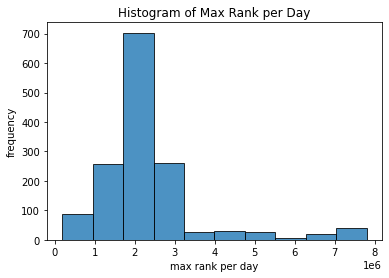

In [26]:
# max rank everyday 
f, axs = plt.subplots(1,1,figsize=(6,4));
axs.hist(max_rank_per_day['max_rank'], edgecolor='k', alpha=0.8);
axs.set(title='Histogram of Max Rank per Day',
        xlabel='max rank per day',
        ylabel='frequency');

NOTE: normalize rank cross-sectionally to get rid off the different size across days.

In [27]:
bsr_full['daily_n_prod'] = bsr_full.groupby('date')['rank'].transform(np.max)
bsr_full['normed_rank'] = bsr_full['rank'] / bsr_full['daily_n_prod'] 
rank_spread = bsr_full.groupby('asin')['normed_rank'].max() - bsr_full.groupby('asin')['normed_rank'].min()

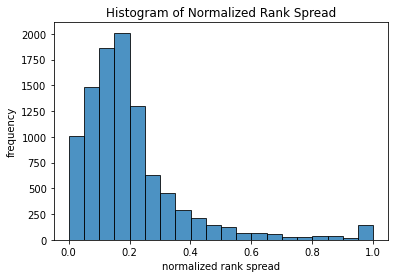

In [28]:
f, axs = plt.subplots(1,1,figsize=(6,4));
axs.hist(rank_spread, bins=20, edgecolor='k', alpha=0.8);
axs.set(title='Histogram of Normalized Rank Spread',
        xlabel='normalized rank spread',
        ylabel='frequency');


NOTE: fair to say most products are relatively stable in terms of relative rank? autoregression?

### review data

In [29]:
review_full = pd.read_csv(f'{data}/raw/asin_review_history.csv')
review_full.head()

,Unnamed: 0,asin,product_name,review_title,review_text,reviewrating,review_date,reviewvotes,reviewverifiedpurchase,reviewcommentcount,temp,country_name
0,0,B00R7FFYO8,Brain Octane Premium C8 MCT Oil from Non-GMO C...,Solution to pouring and storing,This review is being posted more as a solution...,5.0,2017-07-27,"1,652 people found this helpful",True,0,"Reviewed in the United States on July 27, 2017",United States
1,1,B00R7FFYO8,Brain Octane Premium C8 MCT Oil from Non-GMO C...,Works far beyond my expectations.,I work with my husband. He asked me what has g...,5.0,2018-01-09,591 people found this helpful,True,0,"Reviewed in the United States on January 9, 2018",United States
2,2,B00R7FFYO8,Brain Octane Premium C8 MCT Oil from Non-GMO C...,"When you take the cap off,","When you take the cap off, just poke a hole in...",4.0,2017-02-08,"1,205 people found this helpful",True,0,"Reviewed in the United States on February 8, 2017",United States
3,3,B00R7FFYO8,Brain Octane Premium C8 MCT Oil from Non-GMO C...,I'm not even sure this is legit bulletproof oi...,I normally order directly from bulletproof. Am...,1.0,2017-10-11,545 people found this helpful,True,0,"Reviewed in the United States on October 11, 2017",United States
4,4,B00R7FFYO8,Brain Octane Premium C8 MCT Oil from Non-GMO C...,Getting a definite bump in energy during the day.,I've been using this daily for 3 weeks now. I ...,4.0,2017-06-16,857 people found this helpful,True,0,"Reviewed in the United States on June 16, 2017",United States


In [30]:
review_full.shape

(5532637, 12)

In [31]:
review_full['review_date'].min()

'2004-01-09'

In [32]:
review_full['review_date'].max()

'2021-07-17'

In [33]:
review_full['year'] = pd.DatetimeIndex(review_full['review_date']).year

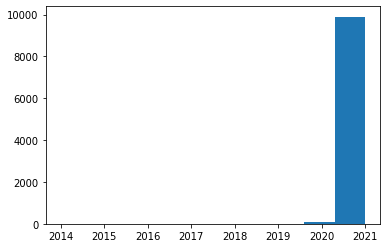

In [34]:
plt.hist(review_full.groupby('asin')['year'].max());

In [35]:
first_review_date = review_full.groupby('asin')['review_date'].min().reset_index().rename(columns={'review_date':'first_review'})
first_rank_date = bsr_full.groupby('asin')['date'].min().reset_index().rename(columns={'date':'first_rank'})
merged_first_date = first_review_date.merge(first_rank_date,how='inner',on='asin')
merged_first_date

,asin,first_review,first_rank
0,2635214875,2014-11-29,2020-02-21
1,B000052XB5,2010-06-05,2017-07-03
2,B00005313T,2007-09-26,2017-07-03
3,B0000533I2,2004-09-12,2017-07-03
4,B00005K9DO,2017-02-09,2017-07-03
...,...,...,...
9953,B096Z9KL3B,2020-10-29,2021-06-21
9954,B096ZMC4PR,2012-04-12,2021-06-18
9955,B0971W5NJD,2021-06-19,2021-06-16
9956,B097C9ZBG1,2019-03-15,2021-06-17


In [36]:
# add a column of numeric review rotes
review_full['reviewvotes_num'] = review_full["reviewvotes"].fillna('0').str.split().str[0].replace('One','1').str.replace(',','').astype('int')

In [37]:
zero_votes = np.mean(review_full['reviewvotes_num']==0)
print("Fraction with 0 votes", zero_votes)
max_votes = review_full['reviewvotes_num'].max()
print("Max number of votes", max_votes)

Fraction with 0 votes 0.6568083176250312
Max number of votes 16368


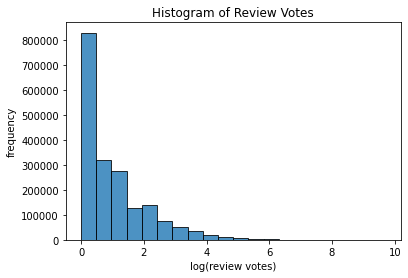

In [38]:
# plot LOG review votes (raw #review votes are super right skewed)
f, axs = plt.subplots(1,1,figsize=(6,4));
axs.hist(np.log(review_full.query('reviewvotes_num>0')['reviewvotes_num']),
         edgecolor='k', alpha=0.8, bins=20);
axs.set(title='Histogram of Review Votes',
        xlabel='log(review votes)',
        ylabel='frequency');


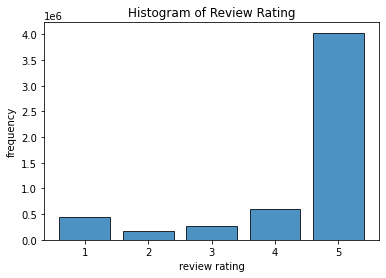

In [39]:
# plot review rating 
f, axs = plt.subplots(1,1,figsize=(6,4));
axs.bar(review_full['reviewrating'].value_counts().index, 
        review_full['reviewrating'].value_counts().values, 
        edgecolor='k', alpha=0.8)
axs.set(title='Histogram of Review Rating',
        xlabel='review rating',
        ylabel='frequency');

In [40]:
# compute #words in each review

# review_full['review_text_len'] = review_full['review_text'].str.split().str.len() # this run out of ram

# work around --- chunck df into 20 iterations
review_full['review_text_len'] = np.nan
chunck_size = review_full.shape[0]//20
idx = 0
while idx < review_full.shape[0]:
  end_idx = min(review_full.shape[0], idx+chunck_size)
  review_full.loc[idx:end_idx,'review_text_len'] = review_full.loc[idx:end_idx, 'review_text'].str.split().str.len().values
  idx += chunck_size


In [41]:
max_len = np.max(review_full["review_text_len"])
print(f'max length:, {max_len}')

short_reviews = np.mean(review_full["review_text_len"] < 10)
print(f'Fraction of reviews below 10 words:, {short_reviews}')

max length:, 4643.0
Fraction of reviews below 10 words:, 0.2873873706154949


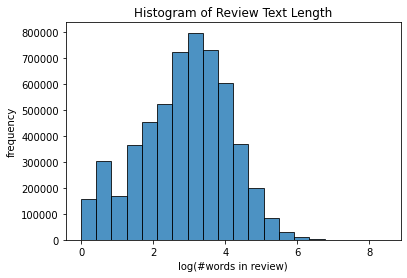

In [42]:
# plot length of reviews
f, axs = plt.subplots(1,1,figsize=(6,4));
axs.hist(np.log(review_full['review_text_len']), bins=20,
         edgecolor='k', alpha=0.8);
axs.set(title='Histogram of Review Text Length',
        xlabel='log(#words in review)',
        ylabel='frequency');

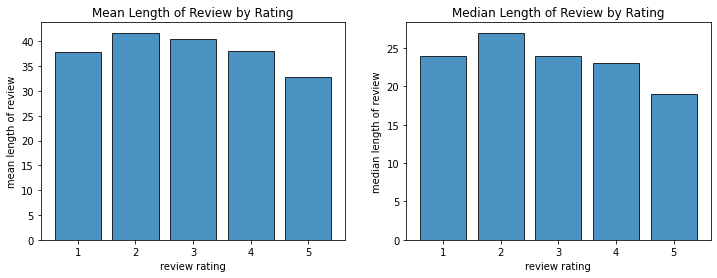

In [43]:
# correlation between length of review and review rating?
mean_len_by_rating = review_full[['reviewrating','review_text_len']].groupby('reviewrating').mean()
med_len_by_rating = review_full[['reviewrating','review_text_len']].groupby('reviewrating').median()

f, axs = plt.subplots(1,2,figsize=(12,4));
axs[0].bar(mean_len_by_rating.index, mean_len_by_rating.review_text_len,
           edgecolor='k', alpha=0.8);
axs[0].set(title='Mean Length of Review by Rating',
           xlabel='review rating',
           ylabel='mean length of review');

axs[1].bar(med_len_by_rating.index, med_len_by_rating.review_text_len,
           edgecolor='k', alpha=0.8);
axs[1].set(title='Median Length of Review by Rating',
           xlabel='review rating',
           ylabel='median length of review');

### price history

In [44]:
price_hist = pd.read_csv(f'{data}/raw/HARVARD_ASIN_PRICE_HISTORY.csv')
price_hist.drop('created_at', axis=1, inplace=True)

In [45]:
np.random.seed(297)
prods = np.random.choice(price_hist['asin'].unique(), size=6)

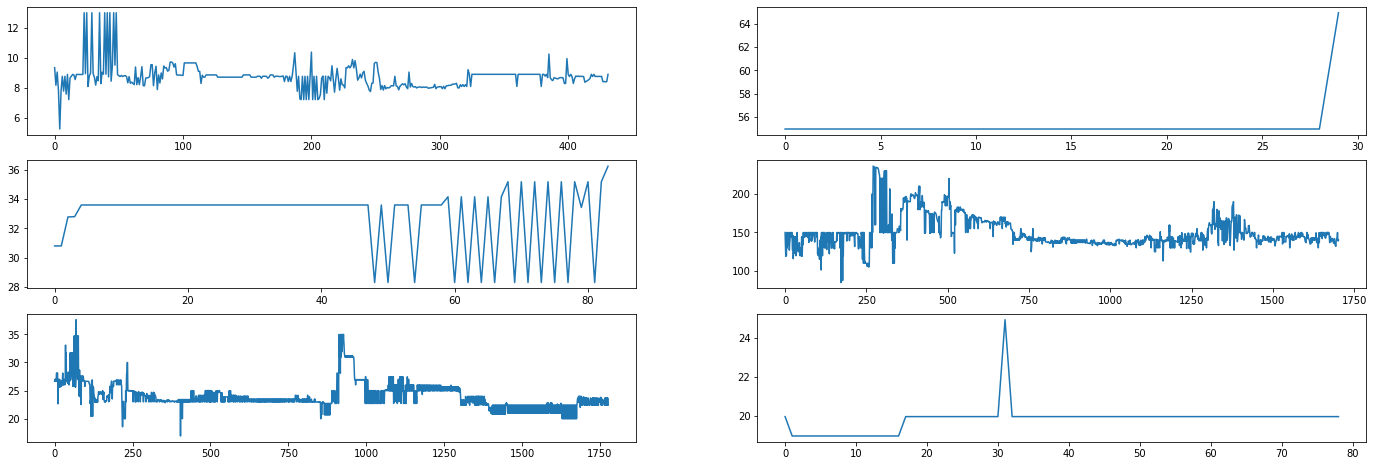

In [46]:
f, axs = plt.subplots(3,2,figsize=(24,8));

for idx, prod in enumerate(prods):
    y = price_hist.query(f'asin == "{prod}"')['buybox_price']
    axs[idx//2, idx%2].plot(range(y.shape[0]), y)

### rank sales

In [47]:
# get id column of both datasets
sales = pd.read_csv(f'{data}/raw/rank_sales.csv')

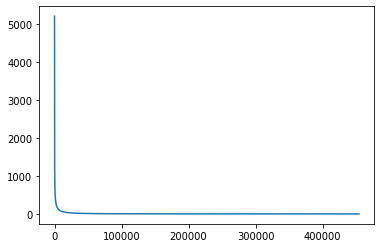

In [48]:
plt.plot(range(sales.shape[0]), sales['sales_estimate'])

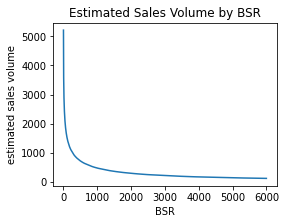

In [49]:
# first 6000 rank 
first = 6000
f, axs = plt.subplots(1,1,figsize=(4,3));
axs.plot(range(first), sales.head(first)['sales_estimate']);
axs.set(title='Estimated Sales Volume by BSR', xlabel='BSR', 
        ylabel='estimated sales volume');

In [50]:
sales.head()

,Unnamed: 0,rank,sales_estimate
0,15226968,1,5214.0
1,15226969,2,4634.0
2,15226970,3,4290.0
3,15226971,4,4046.0
4,15226972,5,3856.0


In [51]:
sales.tail()

,Unnamed: 0,rank,sales_estimate
454297,15681265,454298,0.050010
454298,15681266,454299,0.050008
454299,15681267,454300,0.050006
454300,15681268,454301,0.050004
454301,15681269,454302,0.050002


In [52]:
sales.query('sales_estimate <= 1')

,Unnamed: 0,rank,sales_estimate
201933,15428901,201934,1.000000
201934,15428902,201935,0.999980
201935,15428903,201936,0.999960
201936,15428904,201937,0.999941
201937,15428905,201938,0.999921
...,...,...,...
454297,15681265,454298,0.050010
454298,15681266,454299,0.050008
454299,15681267,454300,0.050006
454300,15681268,454301,0.050004


### look at processed datasets

In [5]:
bsr_raw = pd.read_csv(f'{data}/raw/asin_bsr_history.csv')
bsr_raw['date'] = pd.to_datetime(bsr_raw['date'])
bsr_raw = bsr_raw.sort_values(['asin','date'])

In [6]:
bsr_raw.head()

,Unnamed: 0,date,rank,avg180_price,asin
2521215,2521215,2020-02-21,56154.666667,60.32,2635214875
3484467,3484467,2020-02-21,56154.666667,60.32,2635214875
13981746,13981746,2020-02-21,56154.666667,60.32,2635214875
2521216,2521216,2020-02-22,51188.500000,60.32,2635214875
3484468,3484468,2020-02-22,51188.500000,60.32,2635214875


In [7]:
bsr_prs = pd.read_pickle(f'{data}/clean/month_level_rank.pickle')
bsr_prs['year_month'] = pd.to_datetime(bsr_prs['year_month'])
bsr_prs = bsr_prs.sort_values(['asin','year_month'])

In [8]:
asin_code = 'B00005313T'

In [9]:
raw_rank = bsr_raw.query(f'asin=="{asin_code}"')['rank']
raw_rank_date = bsr_raw.query(f'asin=="{asin_code}"')['date']

In [10]:
dates_in_month = bsr_prs.query(f'asin=="{asin_code}"')['dates_in_month']
dates = []
for row in dates_in_month:
    dates.extend(row)

rolling_med = bsr_prs.query(f'asin=="{asin_code}"')['rolling_median_month_rank']
rolling_med_list = []
for row in rolling_med:
    rolling_med_list.extend(row)

In [11]:
median_month_rank = bsr_prs.query(f'asin=="{asin_code}"')['median_month_rank']
month_date = bsr_prs.query(f'asin=="{asin_code}"')['year_month']

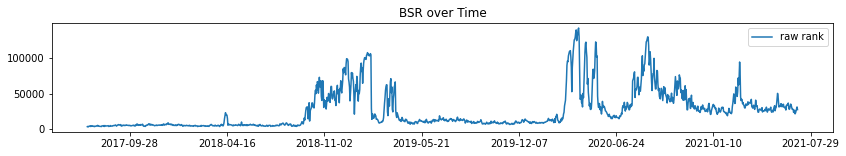

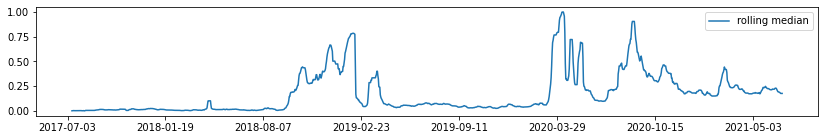

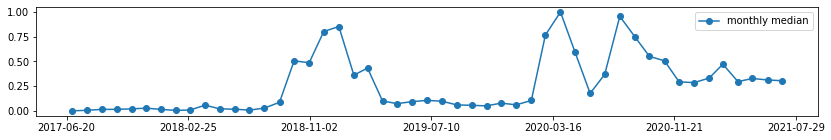

In [12]:
f, axs = plt.subplots(1,1,figsize=(14,2));
axs.plot(raw_rank_date, raw_rank, label='raw rank');
axs.set(title='BSR over Time')
axs.legend()
axs.xaxis.set_major_locator(plt.MaxNLocator(10))

f, axs = plt.subplots(1,1,figsize=(14,2));
axs.plot(dates, rolling_med_list, label='rolling median')
axs.legend()
axs.xaxis.set_major_locator(plt.MaxNLocator(10))

f, axs = plt.subplots(1,1,figsize=(14,2));
axs.plot(month_date, median_month_rank, 'o-', label='monthly median')
axs.legend()
axs.xaxis.set_major_locator(plt.MaxNLocator(8))

In [13]:
sales = pd.read_pickle(f'{data}/clean/month_level_rank_sales_price.pickle')
rev = pd.read_pickle(f'{data}/clean/month_level_review.pickle')
df = rev[['asin', 'year_month']].merge(sales[['asin', 'year_month', 'median_month_est_sales','median_month_rank']], how='inner')

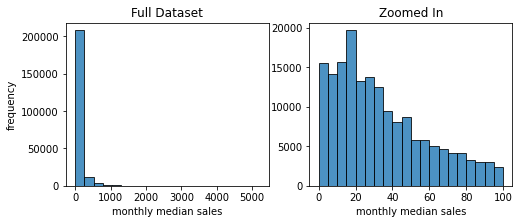

In [14]:
f, axs = plt.subplots(1,2,figsize=(8,3));
axs[0].hist(df['median_month_est_sales'], bins=20, edgecolor='k', density=False, alpha=0.8);
axs[0].set(title='Full Dataset', xlabel='monthly median sales', ylabel='frequency');
axs[1].hist(df.query('median_month_est_sales < 100')['median_month_est_sales'], bins=20, edgecolor='k', density=False, alpha=0.8);
axs[1].set(title='Zoomed In', xlabel='monthly median sales');

In [15]:
df['median_month_est_sales'].describe()

count    226637.000000
mean         99.470889
std         208.381597
min           0.024907
25%          18.078906
50%          39.618164
75%          96.171875
max        5214.000000
Name: median_month_est_sales, dtype: float64

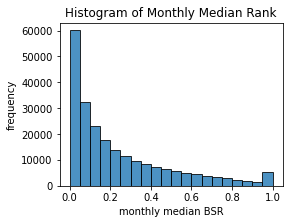

In [16]:
f, axs = plt.subplots(1,1,figsize=(4,3));
axs.hist(df['median_month_rank'], bins=20, edgecolor='k', density=False, alpha=0.8);
axs.set(title='Histogram of Monthly Median Rank', xlabel='monthly median BSR', ylabel='frequency');